In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import copy
import itertools
import matplotlib.pyplot as plt

In [2]:
def sample(law=stats.norm, params=tuple(), size=10, seed=1):
    np.random.seed(seed)
    dist = law(*params)
    sample = np.array(dist.rvs(size=size))
    kss = stats.ks_1samp(sample, dist.cdf)
    fit = law.fit(sample)
    dist2 = law(*fit)
    sample2 = dist2.rvs(size=size)
    ks20 = stats.ks_1samp(sample2, dist.cdf)
    ks21 = stats.ks_1samp(sample, dist2.cdf)
    ks22 = stats.ks_1samp(sample2, dist2.cdf)
    ks23 = stats.ks_2samp(sample, sample2)
    return {
        "law": law,
        "dist": dist,
        "name": law.name, #__class__.__name__,
        "label": "{}{}".format(law.name, params),
        "hash": id(dist),
        "params": params,
        "seed": seed,
        "size": size,
        "sample": sample,
        "kss_p": kss.pvalue,
        "kss_s": kss.statistic,
        "fit": fit,
        "ks20": ks20.pvalue,
        "ks21": ks21.pvalue,
        "ks22": ks22.pvalue,
        "ks23": ks23.pvalue,
    }

In [3]:
tests = [
    {
        "law": stats.norm,
        "params": [(0.1,), (1.0,), (10.0,)]
    },
    {
        "law": stats.lognorm,
        "params": [(0.1,), (1.0,), (10.0,)]
    }
]

In [4]:
def combine(tests, sizes, seeds):
    for test in copy.deepcopy(tests):
        for params in test.pop("params"):
            for size, seed in itertools.product(sizes, seeds):
                yield sample(params=params, size=size, seed=seed, **test)

In [5]:
N = np.array([1, 5, 10, 15, 20, 30, 50, 100, 200, 1000, 5000, 10000, 20000])
S = np.arange(30)*(np.max(N) + 1)*2
S

array([      0,   40002,   80004,  120006,  160008,  200010,  240012,
        280014,  320016,  360018,  400020,  440022,  480024,  520026,
        560028,  600030,  640032,  680034,  720036,  760038,  800040,
        840042,  880044,  920046,  960048, 1000050, 1040052, 1080054,
       1120056, 1160058])

In [6]:
df = pd.DataFrame(combine(tests, N, S))
df.sample(5)

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1844: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


,law,dist,name,label,hash,params,seed,size,sample,kss_p,kss_s,fit,ks20,ks21,ks22,ks23
467,<scipy.stats._continuous_distns.norm_gen objec...,<scipy.stats._distn_infrastructure.rv_frozen o...,norm,"norm(1.0,)",140571271492160,"(1.0,)",680034,10,"[-0.208982003697314, 0.05529644175322401, 1.44...",0.657498,0.217231,"(0.8899115265274429, 1.0973313040118713)",0.089437,0.912410,0.200731,0.786930
1238,<scipy.stats._continuous_distns.lognorm_gen ob...,<scipy.stats._distn_infrastructure.rv_frozen o...,lognorm,"lognorm(0.1,)",140571265436864,"(0.1,)",320016,10,"[0.8466216603691359, 1.0312520471322095, 1.146...",0.393149,0.269083,"(0.01013536324781257, -9.861079127358824, 10.8...",0.819190,0.603816,0.586912,0.417524
108,<scipy.stats._continuous_distns.norm_gen objec...,<scipy.stats._distn_infrastructure.rv_frozen o...,norm,"norm(0.1,)",140571409488080,"(0.1,)",720036,15,"[-1.5327682763633341, 0.7799571328024278, 0.53...",0.149223,0.282616,"(-0.2015506295785969, 1.4853508032718903)",0.457909,0.950931,0.777725,0.678138
2253,<scipy.stats._continuous_distns.lognorm_gen ob...,<scipy.stats._distn_infrastructure.rv_frozen o...,lognorm,"lognorm(10.0,)",140571257017848,"(10.0,)",120006,5000,"[5.319504308590214e-08, 0.0016565508058890607,...",0.320225,0.013486,"(3.3543780090656465, -5153.279585735174, 42047...",0.000000,0.000000,0.838948,0.000000
929,<scipy.stats._continuous_distns.norm_gen objec...,<scipy.stats._distn_infrastructure.rv_frozen o...,norm,"norm(10.0,)",140571267990304,"(10.0,)",1160058,20,"[8.91708422595156, 10.644078380646084, 8.63120...",0.056831,0.288890,"(9.479548449228478, 0.9567076662171046)",0.250520,0.894196,0.383307,0.831970


In [7]:
df.to_pickle("law_sample.pickle")

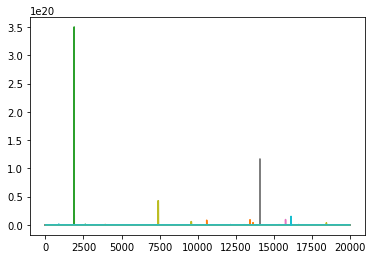

In [8]:
fig, axe = plt.subplots()
for row in df.itertuples():
    axe.plot(row.sample)

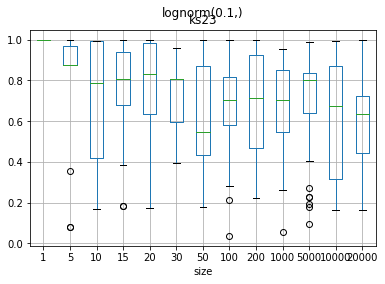

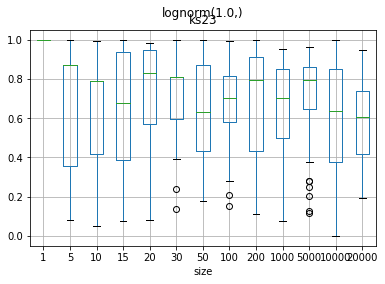

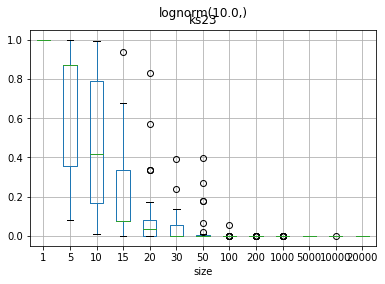

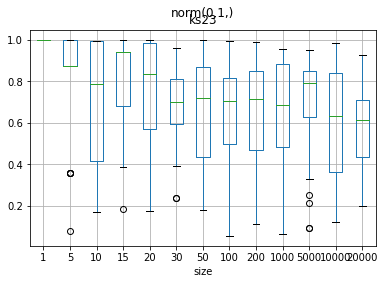

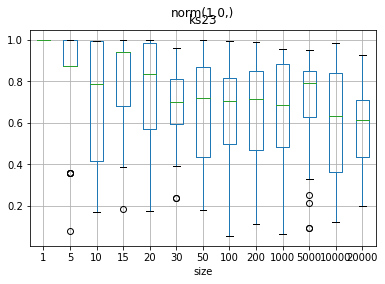

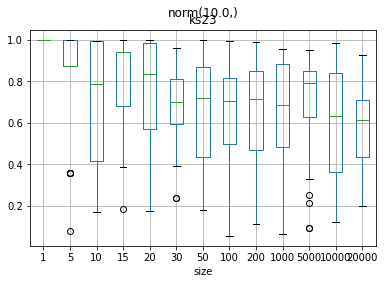

In [9]:
g1s = df.groupby(["label"])
for g1k in g1s.groups:
    key = g1s.groups[g1k]
    axe = df.loc[key,:].boxplot("ks23", by="size")
    axe.figure.suptitle(g1k)